In [1]:
# coding: utf-8
import time
import os
import numpy as np
from sklearn.model_selection import train_test_split
from gensim.utils import simple_preprocess

import keras
from keras import metrics
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.layers.embeddings import Embedding

from datetime import datetime
from collections import *
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%run common.ipynb
%run word2vec_loader.ipynb

In [3]:
# Read pickle and split training and testing sets
df = pd.read_pickle('train_reduce.pkl')
train_df, test_df = train_test_split(df, test_size=0.8, shuffle=False)
train_df, test_df = test_df, train_df

print('Rows of dataset=%d, training set rows=%s, testing set rows=%d' % (len(df), len(train_df), len(test_df)))

Rows of dataset=946, training set rows=757, testing set rows=189


In [4]:
# Generate word embedding matrix and word2idx dict
embedding_matrix, word2idx = createEmbeddingMatrix(EMBEDDING_DIM)

Word2Vec(vocab=22839, size=100, alpha=0.025)
embedding_matrix.shape=(22840, 100)


In [5]:
# print(type(train_df[:10]['ari_title']))
# train_df_list = list(train_df[0:757]['ari_title'])
# print(type(train_df_list), len(train_df_list), train_df_list[:3])
# train_df_list = train_df[:10]['ari_title']
# print(train_df[:10])

In [6]:
# Create training inputs
# print(type(train_df), type(train_df_list), type(word2idx))
# train_df_titie = pd.DataFrame({'ari_title': train_df_list})

x_texts_idx = text_to_index(train_df['ari_title'], word2idx)
x_texts_idx_pad = pad_sequences(x_texts_idx, maxlen=MAX_WORD_COUNT)
X_train = x_texts_idx_pad
# X_train = np.insert(x_texts_idx_pad, 0, train_df['ari_time'].values, axis=1)

Y_train = train_df['price']
# assert(len(X_train) == len(Y_train))
# print(train_df.shape, len(train_df_list), x_texts_idx.shape, X_train.shape, Y_train.shape)
print( X_train.shape, Y_train.shape)

# print(np.count_nonzero(X_train))
# print(x_texts_idx)

(757, 20) (757,)


In [25]:
# Model definition
model = Sequential()
# input_dim=embedding_matrix.shape[0]
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_WORD_COUNT, trainable=False)
model.add(embedding_layer)

# model.add(LSTM(16))
# model.add(Dense(40, activation='relu'))
# model.add(Dense(20, activation='relu'))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.3))
# model.add(GRU(96, return_sequences=True))
# model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(48, return_sequences=True))
# model.add(Dropout(0.2))
model.add(GRU(32, return_sequences=True))
model.add(Dropout(0.3))
# model.add(GRU(24, return_sequences=True))
# model.add(Dropout(0.3))
model.add(GRU(16))
model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# prev: optimizer=adam
# rmsprop: default lr=0.001
# rmsprop2 = keras.optimizers.RMSprop(lr=0.05)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 100)           2284000   
_________________________________________________________________
gru_24 (GRU)                 (None, 20, 256)           274176    
_________________________________________________________________
dropout_15 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
gru_25 (GRU)                 (None, 20, 128)           147840    
_________________________________________________________________
dropout_16 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
gru_26 (GRU)                 (None, 20, 64)            37056     
_________________________________________________________________
dropout_17 (Dropout)         (None, 20, 64)            0         
__________

In [26]:
init_epoch = 0
num_epochs = 150 #300
num_batch_size = 100  # 100

# Load previous model
# init_epoch = 98
# model_path = 'models_intermediate/epoch%04d.h5' % init_epoch
# print('Loadinig model', model_path)
# model = load_model(model_path)

# Model checkpoint
filepath="models_intermediate/epoch{epoch:04d}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x=X_train, y=Y_train, batch_size=num_batch_size, 
                    initial_epoch=init_epoch, epochs=num_epochs, 
                    callbacks=callbacks_list, verbose=1) 

Epoch 1/150
757/757 [==============================] - 8s 11ms/step - loss: 0.6338 - acc: 0.7067

Epoch 00001: acc improved from -inf to 0.70674, saving model to models_intermediate/epoch0001.h5
Epoch 2/150
757/757 [==============================] - 2s 3ms/step - loss: 0.6077 - acc: 0.7120

Epoch 00002: acc improved from 0.70674 to 0.71202, saving model to models_intermediate/epoch0002.h5
Epoch 3/150
757/757 [==============================] - 2s 3ms/step - loss: 0.6040 - acc: 0.7120

Epoch 00003: acc improved from 0.71202 to 0.71202, saving model to models_intermediate/epoch0003.h5
Epoch 4/150
757/757 [==============================] - 2s 3ms/step - loss: 0.5834 - acc: 0.7120

Epoch 00004: acc improved from 0.71202 to 0.71202, saving model to models_intermediate/epoch0004.h5
Epoch 5/150
757/757 [==============================] - 2s 3ms/step - loss: 0.5506 - acc: 0.7120

Epoch 00005: acc improved from 0.71202 to 0.71202, saving model to models_intermediate/epoch0005.h5
Epoch 6/150
757/7

757/757 [==============================] - 2s 3ms/step - loss: 0.1925 - acc: 0.9762

Epoch 00053: acc did not improve
Epoch 54/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1842 - acc: 0.9841

Epoch 00054: acc improved from 0.98283 to 0.98415, saving model to models_intermediate/epoch0054.h5
Epoch 55/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1881 - acc: 0.9815

Epoch 00055: acc did not improve
Epoch 56/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1779 - acc: 0.9841

Epoch 00056: acc did not improve
Epoch 57/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1801 - acc: 0.9815

Epoch 00057: acc did not improve
Epoch 58/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1770 - acc: 0.9868

Epoch 00058: acc improved from 0.98415 to 0.98679, saving model to models_intermediate/epoch0058.h5
Epoch 59/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1743 - acc: 0.9

757/757 [==============================] - 2s 3ms/step - loss: 0.1210 - acc: 0.9921

Epoch 00113: acc did not improve
Epoch 114/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1229 - acc: 0.9921

Epoch 00114: acc did not improve
Epoch 115/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1221 - acc: 0.9921

Epoch 00115: acc did not improve
Epoch 116/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1237 - acc: 0.9921

Epoch 00116: acc did not improve
Epoch 117/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1219 - acc: 0.9921

Epoch 00117: acc did not improve
Epoch 118/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1200 - acc: 0.9921

Epoch 00118: acc did not improve
Epoch 119/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1207 - acc: 0.9921

Epoch 00119: acc did not improve
Epoch 120/150
757/757 [==============================] - 2s 3ms/step - loss: 0.1210 - acc:

In [27]:
model.save('models/my_model.h5')

accuracy 準確度: 


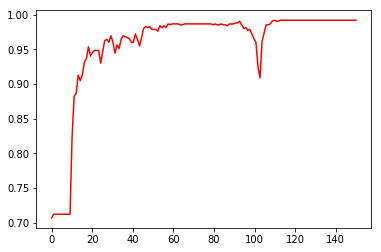

loss 損失函數: 


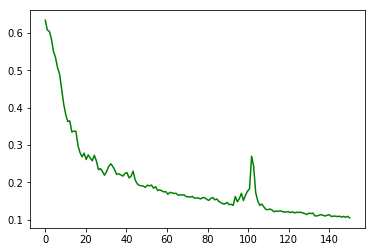

In [28]:
# Plot accuracy and loss chart
np_loss_history = np.array(history.history['loss'])
np.savetxt("loss_history.txt", np_loss_history, delimiter=",")
loss_history = np.loadtxt("loss_history.txt")

np_acc_history = np.array(history.history['acc'])
np.savetxt("acc_history.txt", np_acc_history, delimiter=",")
acc_history = np.loadtxt("acc_history.txt")

print("accuracy 準確度: ")
fig = plt.figure(1)
ax = plt.axes()
x = np.linspace(0, num_epochs, acc_history.shape[0])
plt.plot(x, acc_history, '-r');  # dotted red
plt.show()


print("loss 損失函數: ")
fig = plt.figure(2)
ax = plt.axes()
x = np.linspace(0, num_epochs, loss_history.shape[0])
plt.plot(x, loss_history, '-g');  # dotted red
plt.show()

In [29]:
##### Model Evaluation #####

In [30]:
# Model evaluation by training data
n_first = len(X_train)
loss_accuracy = model.evaluate(X_train[0:n_first], Y_train[0:n_first], verbose=1)
print('loss=%.4f, accuracy=%.4f' % (loss_accuracy[0], loss_accuracy[1]))

print(X_train)

757/757 [==============================] - 3s 3ms/step
loss=0.1046, accuracy=0.9921
[[ 7957 12994 14551 ... 15713 10782 13276]
 [    0     0     0 ... 17796 14583  7904]
 [20673 16407   439 ... 15280 19983  5207]
 ...
 [    0     0     0 ...  3466  3900 17799]
 [    0     0     0 ...  1193  9559  4572]
 [    0     0     0 ...   767  5478 16495]]


In [31]:
# Create testing inputs
x_test_texts_idx = text_to_index(test_df['ari_title'], word2idx)
X_test = pad_sequences(x_test_texts_idx, maxlen=MAX_WORD_COUNT)

Y_test = test_df['price']
assert(len(X_test) == len(Y_test))
print(X_test.shape, Y_test.shape)

(189, 20) (189,)


In [32]:
# Model evaluation by testing data
n_first = len(X_test)
loss_accuracy = model.evaluate(X_test[80:n_first], Y_test[80:n_first], verbose=1)
print('loss=%.4f, accuracy=%.4f' % (loss_accuracy[0], loss_accuracy[1]))

109/109 [==============================] - 0s 2ms/step
loss=1.4225, accuracy=0.6422
